# SmartInvest — Colab Notebook (Full pipeline, with user ticker input)

In [18]:
%pip install -q yfinance pandas numpy requests beautifulsoup4 nltk matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.


In [35]:
import nltk
nltk.download('vader_lexicon')
print('Dependencies installed and VADER downloaded.')

Dependencies installed and VADER downloaded.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [20]:
import os, time
from datetime import datetime, timedelta
from typing import List, Dict

import numpy as np
import pandas as pd
import yfinance as yf
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import matplotlib.pyplot as plt

from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline
print('Libraries imported.')


Libraries imported.


In [21]:
# --- Configuration (user input) ---
user_ticker = input("Enter a ticker symbol (e.g., RELIANCE.NS). Leave blank to use defaults: ").strip().upper()
if user_ticker:
    TICKERS = [user_ticker]
else:
    TICKERS = ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS"]


NEWSAPI_KEY = ""  # optional: set your NewsAPI.org key here
MAX_NEWS_PER_TICKER = 20

SCORE_WEIGHTS = {
    "sentiment": 0.3,
    "technical": 0.3,
    "fundamental": 0.4
}
SCORE_THRESHOLD = 0.6

os.makedirs('figures', exist_ok=True)
print('Ticker(s) to analyze:', TICKERS)


Ticker(s) to analyze: ['TCS.NS']


In [22]:

def fetch_price_data(tickers: List[str], period: str = "1y") -> pd.DataFrame:
    """Fetch Close price series for tickers using yfinance."""
    data = yf.download(tickers, period=period, interval='1d', group_by='ticker', progress=False)
    out = {}
    if isinstance(data.columns, pd.MultiIndex):
        for t in tickers:
            try:
                out[t] = data[t]['Close']
            except Exception:
                if 'Close' in data.columns:
                    out[t] = data['Close']
                else:
                    out[t] = data.iloc[:, 0]
    else:
        if 'Close' in data.columns:
            out[tickers[0]] = data['Close']
        else:
            out[tickers[0]] = data.iloc[:, 0]
    df = pd.DataFrame(out)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    return df

print('Price fetch function ready.')


Price fetch function ready.


In [23]:

def fetch_fundamentals(ticker: str) -> Dict[str, float]:
    tk = yf.Ticker(ticker)
    try:
        info = tk.get_info()
    except Exception:
        info = {}
    revenue = info.get('totalRevenue') or info.get('revenue') or np.nan
    net_income = info.get('netIncomeToCommon') or info.get('netIncome') or np.nan
    trailingPE = info.get('trailingPE') or np.nan
    eps = info.get('trailingEps') or np.nan
    return {
        'revenue': float(revenue) if revenue not in (None, {}) else np.nan,
        'net_income': float(net_income) if net_income not in (None, {}) else np.nan,
        'trailingPE': float(trailingPE) if trailingPE not in (None, {}) else np.nan,
        'eps': float(eps) if eps not in (None, {}) else np.nan,
    }

print('Fundamentals fetch function ready.')


Fundamentals fetch function ready.


In [24]:

def fetch_news_for_ticker(ticker: str, company_name: str = None, max_articles: int = 20) -> pd.DataFrame:
    articles = []
    query = (company_name or ticker.replace('.NS', '')).strip()
    if NEWSAPI_KEY:
        url = 'https://newsapi.org/v2/everything'
        params = {
            'q': query,
            'pageSize': max_articles,
            'language': 'en',
            'sortBy': 'publishedAt',
            'apiKey': NEWSAPI_KEY
        }
        try:
            r = requests.get(url, params=params, timeout=15)
            data = r.json()
            for art in data.get('articles', []):
                articles.append({
                    'ticker': ticker,
                    'title': art.get('title'),
                    'description': art.get('description'),
                    'content': art.get('content'),
                    'publishedAt': art.get('publishedAt'),
                    'source': art.get('source', {}).get('name')
                })
        except Exception as e:
            print('NewsAPI fetch failed for', ticker, e)
    else:
        rss_url = f"https://news.google.com/rss/search?q={query}+when:7d&hl=en-IN&gl=IN&ceid=IN:en"
        try:
            r = requests.get(rss_url, timeout=10)
            soup = BeautifulSoup(r.content, 'xml')
            items = soup.find_all('item')[:max_articles]
            for it in items:
                articles.append({
                    'ticker': ticker,
                    'title': it.title.text if it.title else None,
                    'description': it.description.text if it.description else None,
                    'content': None,
                    'publishedAt': it.pubDate.text if it.pubDate else None,
                    'source': it.source.text if it.source else None
                })
        except Exception as e:
            print('Google News fetch failed for', ticker, e)
    df = pd.DataFrame(articles)
    if not df.empty:
        df['publishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')
        df = df.drop_duplicates(subset=['title']).reset_index(drop=True)
    return df

print('News fetch function ready.')


News fetch function ready.


In [25]:

sia = SentimentIntensityAnalyzer()

def preprocess_and_score_news(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty:
        return pd.DataFrame(columns=['ticker','title','description','text','publishedAt','source','neg','neu','pos','compound'])
    df = df.copy()
    df['title'] = df['title'].astype(str)
    df['description'] = df.get('description', '').fillna('').astype(str)
    df['text'] = (df['title'] + '. ' + df['description']).str.strip()
    scores = df['text'].apply(lambda t: sia.polarity_scores(t) if str(t).strip() else {'neg':0,'neu':1,'pos':0,'compound':0})
    scores_df = pd.DataFrame(list(scores))
    df = pd.concat([df.reset_index(drop=True), scores_df.reset_index(drop=True)], axis=1)
    return df

print('Sentiment scoring ready.')


Sentiment scoring ready.


In [26]:

def compute_technicals(close_series: pd.Series) -> pd.DataFrame:
    df = close_series.rename('Close').to_frame()
    df['SMA50'] = df['Close'].rolling(window=50, min_periods=10).mean()
    df['SMA200'] = df['Close'].rolling(window=200, min_periods=50).mean()
    df['Momentum30'] = df['Close'] - df['Close'].shift(30)
    df['Volatility30'] = df['Close'].rolling(window=30, min_periods=10).std()
    return df

def technical_score_for_latest(df: pd.DataFrame) -> float:
    if df is None or df.empty:
        return 0.5
    latest = df.dropna(how='all').tail(1).iloc[0]
    score = 0.5
    try:
        if not np.isnan(latest.get('SMA50')) and not np.isnan(latest.get('SMA200')):
            score += 0.2 if latest['SMA50'] > latest['SMA200'] else -0.1
    except Exception:
        pass
    try:
        if not np.isnan(latest.get('Momentum30')):
            score += 0.15 if latest['Momentum30'] > 0 else -0.1
    except Exception:
        pass
    try:
        vol = latest.get('Volatility30', np.nan)
        if not np.isnan(vol) and not np.isnan(latest.get('Close')):
            vol_pen = min(0.2, (vol / (latest['Close'] + 1e-9)))
            score -= vol_pen
    except Exception:
        pass
    return float(np.clip(score, 0.0, 1.0))

print('Technical indicator functions ready.')


Technical indicator functions ready.


In [27]:

def fundamental_score_from_info(info: Dict[str,float]) -> float:
    score = 0.5
    try:
        net_income = info.get('net_income', np.nan)
        if not np.isnan(net_income) and net_income > 0:
            score += 0.15
    except Exception:
        pass
    try:
        pe = info.get('trailingPE', np.nan)
        if not np.isnan(pe):
            if pe <= 25:
                score += 0.1
            elif pe <= 50:
                score += 0.02
            else:
                score -= 0.15
    except Exception:
        pass
    try:
        eps = info.get('eps', np.nan)
        if not np.isnan(eps) and eps > 0:
            score += 0.05
    except Exception:
        pass
    return float(np.clip(score, 0.0, 1.0))

print('Fundamental scoring ready.')


Fundamental scoring ready.


In [28]:

def compute_composite_score(sentiment_s, technical_s, fundamental_s, weights=SCORE_WEIGHTS) -> float:
    s = weights['sentiment'] * sentiment_s + weights['technical'] * technical_s + weights['fundamental'] * fundamental_s
    return float(np.clip(s, 0.0, 1.0))

def recommend_label(score: float, threshold: float = SCORE_THRESHOLD) -> str:
    if score >= threshold:
        return "Invest"
    elif score >= (threshold - 0.15):
        return "Hold"
    else:
        return "Not confident"

print('Composite functions ready.')


Composite functions ready.


In [29]:

def run_pipeline(tickers: List[str] = TICKERS, days: int = 365):
    end = datetime.today()
    start = end - timedelta(days=days)
    print("Fetching price data...")
    prices = fetch_price_data(tickers, period=f"{days}d")

    print("Computing technical indicators...")
    techs = {t: compute_technicals(prices[t].dropna()) if t in prices.columns else pd.DataFrame() for t in tickers}

    # news & sentiment
    all_news = []
    for t in tqdm(tickers, desc="Fetching news"):
        nd = fetch_news_for_ticker(t, max_articles=MAX_NEWS_PER_TICKER)
        nd = preprocess_and_score_news(nd)
        if not nd.empty:
            all_news.append(nd)
        time.sleep(0.2)
    news_df = pd.concat(all_news, ignore_index=True) if all_news else pd.DataFrame()

    # aggregate sentiment
    if not news_df.empty:
        sentiment_agg = news_df.groupby('ticker')['compound'].agg(['mean','count']).reset_index().rename(columns={'mean':'sentiment_compound','count':'news_count'})
    else:
        sentiment_agg = pd.DataFrame(columns=['ticker','sentiment_compound','news_count'])

    rows = []
    for t in tickers:
        fund = fetch_fundamentals(t)
        fscore = fundamental_score_from_info(fund)
        tdf = techs.get(t)
        tscore = technical_score_for_latest(tdf) if tdf is not None and not tdf.empty else 0.5
        sent_row = sentiment_agg[sentiment_agg['ticker']==t]
        sscore = float(sent_row['sentiment_compound'].values[0]) if not sent_row.empty else 0.0
        sscore_rescaled = float((sscore + 1) / 2)
        composite = compute_composite_score(sscore_rescaled, tscore, fscore)
        label = recommend_label(composite)
        last_price = float(prices[t].dropna().iloc[-1]) if t in prices.columns and prices[t].dropna().size>0 else np.nan
        rows.append({
            'ticker': t,
            'sentiment_raw': sscore,
            'sentiment': sscore_rescaled,
            'technical': tscore,
            'fundamental': fscore,
            'composite_score': composite,
            'recommendation': label,
            'news_count': int(sent_row['news_count'].values[0]) if not sent_row.empty else 0,
            'last_price': last_price
        })

    results_df = pd.DataFrame(rows).sort_values('composite_score', ascending=False).reset_index(drop=True)
    # save CSV
    results_df.to_csv('smartinvest_results.csv', index=False)
    print('Saved smartinvest_results.csv')
    return results_df, news_df, techs


In [30]:
results_df, news_df, techs = run_pipeline(TICKERS, days=365)
results_df

Fetching price data...


C:\Users\Asus\AppData\Local\Temp\ipykernel_5044\4257494303.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period, interval='1d', group_by='ticker', progress=False)


Computing technical indicators...


Fetching news:   0%|          | 0/1 [00:00<?, ?it/s]

Google News fetch failed for TCS.NS Couldn't find a tree builder with the features you requested: xml. Do you need to install a parser library?


Fetching news: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Saved smartinvest_results.csv


,ticker,sentiment_raw,sentiment,technical,fundamental,composite_score,recommendation,news_count,last_price
0,TCS.NS,0.0,0.5,0.532533,0.8,0.62976,Invest,0,3144.800049


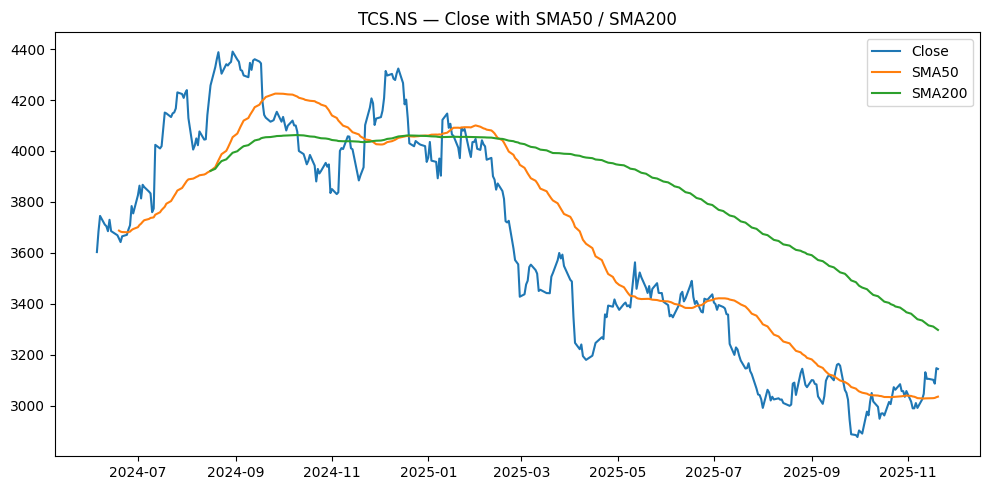

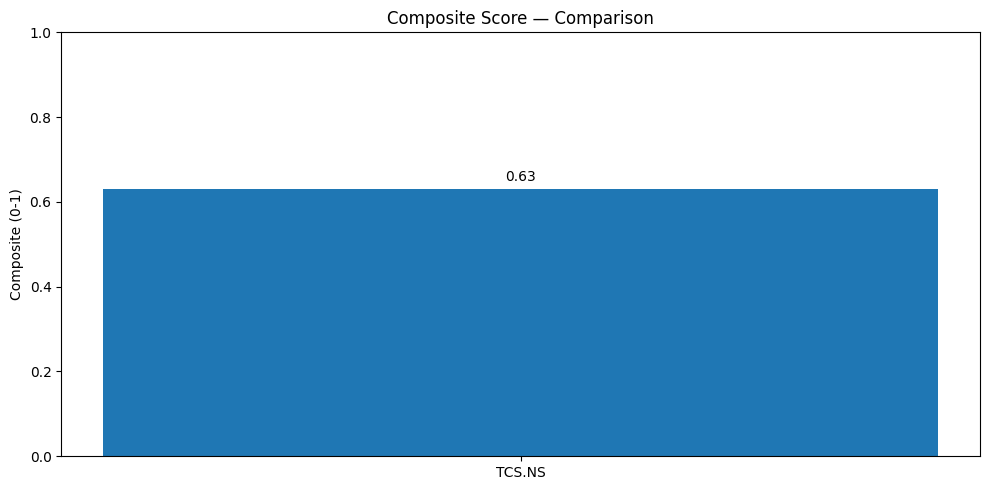

Google News fetch failed for TCS.NS Couldn't find a tree builder with the features you requested: xml. Do you need to install a parser library?


In [31]:

# Ensure figures folder exists
os.makedirs('figures', exist_ok=True)

# SMA plots
for t in TICKERS:
    td = techs.get(t)
    if td is None or td.empty:
        continue
    plt.figure(figsize=(10,5))
    plt.plot(td.index, td['Close'], label='Close')
    if 'SMA50' in td.columns:
        plt.plot(td.index, td['SMA50'], label='SMA50')
    if 'SMA200' in td.columns:
        plt.plot(td.index, td['SMA200'], label='SMA200')
    plt.title(f"{t} — Close with SMA50 / SMA200")
    plt.legend()
    plt.tight_layout()
    fname = f"figures/{t.replace('.','_')}_sma.png"
    plt.savefig(fname, dpi=150)
    plt.show()
    plt.close()

# Composite bar
plt.figure(figsize=(10,5))
sorted_df = results_df.sort_values('composite_score', ascending=False)
plt.bar(sorted_df['ticker'], sorted_df['composite_score'])
plt.ylim(0,1)
plt.title('Composite Score — Comparison')
plt.ylabel('Composite (0-1)')
for i, v in enumerate(sorted_df['composite_score'].values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.savefig('figures/composite_bar.png', dpi=150)
plt.show()

# News table image (top 5 per ticker)
import math
all_news_fig_rows = []
for t in TICKERS:
    news = fetch_news_for_ticker(t)
    if news.empty:
        continue
    news = preprocess_and_score_news(news)
    if 'publishedAt' in news.columns:
        news['publishedAt'] = pd.to_datetime(news['publishedAt'], errors='coerce')
        news = news.sort_values('publishedAt', ascending=False)
    top = news.head(5)[['publishedAt','title','compound']].copy()
    top['publishedAt'] = top['publishedAt'].astype(str)
    top['compound'] = top['compound'].round(3)
    top['ticker'] = t
    all_news_fig_rows.append(top)

if len(all_news_fig_rows) > 0:
    all_news_table = pd.concat(all_news_fig_rows, ignore_index=True)
    fig, ax = plt.subplots(figsize=(12, max(3, math.ceil(len(all_news_table)/3))))
    ax.axis('off')
    tbl = ax.table(cellText=all_news_table.values,
                   colLabels=all_news_table.columns,
                   loc='center',
                   cellLoc='left')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1, 1.5)
    plt.title('Recent News (top 5 per ticker) — compound sentiment')
    plt.tight_layout()
    plt.savefig('figures/news_table.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()


In [32]:

from matplotlib.backends.backend_pdf import PdfPages
pdf_path = 'smartinvest_report.pdf'
with PdfPages(pdf_path) as pdf:
    # Title page
    fig = plt.figure(figsize=(11.69,8.27))
    fig.suptitle('SmartInvest — Phase I Visual Report', fontsize=18, y=0.9)
    plt.axis('off')
    plt.figtext(0.1, 0.7, f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", fontsize=10)
    plt.figtext(0.1, 0.6, 'Components: Price + SMAs, Technicals, News Sentiment, Composite Scores', fontsize=10)
    pdf.savefig(); plt.close()

    # Per-ticker SMA charts
    for t in TICKERS:
        td = techs.get(t)
        if td is None or td.empty:
            continue
        fig, ax = plt.subplots(figsize=(11.69,8.27))
        ax.plot(td.index, td['Close'], label='Close')
        if 'SMA50' in td.columns: ax.plot(td.index, td['SMA50'], label='SMA50')
        if 'SMA200' in td.columns: ax.plot(td.index, td['SMA200'], label='SMA200')
        ax.set_title(f"{t} — Price with SMAs")
        ax.legend()
        pdf.savefig(); plt.close()

    # Composite bar chart
    fig, ax = plt.subplots(figsize=(11.69,8.27))
    ax.bar(sorted_df['ticker'], sorted_df['composite_score'])
    ax.set_ylim(0,1)
    ax.set_title('Composite Score — Comparison')
    ax.set_ylabel('Composite (0-1)')
    for i, v in enumerate(sorted_df['composite_score'].values):
        ax.text(i, v + 0.02, f"{v:.2f}", ha='center')
    pdf.savefig(); plt.close()

    # Results table page
    results_page = results_df.copy()
    fig, ax = plt.subplots(figsize=(11.69,8.27))
    ax.axis('off')
    tbl = ax.table(cellText=results_page.values,
                   colLabels=results_page.columns,
                   loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1, 1.5)
    ax.set_title('SmartInvest Results')
    pdf.savefig(); plt.close()

    # News table page (if exists)
    try:
        img = plt.imread('figures/news_table.png')
        fig, ax = plt.subplots(figsize=(11.69,8.27))
        ax.imshow(img)
        ax.axis('off')
        pdf.savefig(); plt.close()
    except Exception:
        pass

print('Saved PDF:', pdf_path)


Saved PDF: smartinvest_report.pdf


In [33]:

results_df.to_csv('smartinvest_results.csv', index=False)
print('Saved smartinvest_results.csv and smartinvest_report.pdf')

try:
    from google.colab import files
    files.download('smartinvest_results.csv')
    files.download('smartinvest_report.pdf')
except Exception:
    print('Not in Colab environment — files are saved to the VM (figures/, smartinvest_results.csv, smartinvest_report.pdf)')


Saved smartinvest_results.csv and smartinvest_report.pdf
Not in Colab environment — files are saved to the VM (figures/, smartinvest_results.csv, smartinvest_report.pdf)


In [34]:

import math
import pandas as pd
import numpy as np

def build_fundamentals_table(tickers):
    rows = []
    for t in tickers:
        info = {}
        try:
            tk = yf.Ticker(t)
            info_raw = tk.get_info()
        except Exception:
            info_raw = {}

        # extract fields (best-effort)
        market_price = float(results_df.loc[results_df['ticker']==t, 'last_price'].values[0]) if (t in results_df['ticker'].values) else (info_raw.get('previousClose') or np.nan)
        total_revenue = info_raw.get('totalRevenue') or info_raw.get('revenue') or np.nan
        net_income = info_raw.get('netIncomeToCommon') or info_raw.get('netIncome') or np.nan
        revenue_yoy = info_raw.get('revenueGrowth') or info_raw.get('yoy') or np.nan
        net_margin = (net_income / total_revenue) if (not pd.isna(total_revenue) and total_revenue != 0) else np.nan
        trailing_eps = info_raw.get('trailingEps') or np.nan
        trailing_pe = info_raw.get('trailingPE') or np.nan
        shares_outstanding = info_raw.get('sharesOutstanding') or np.nan

        rows.append({
            'ticker': t,
            'market_price': market_price,
            'total_revenue': float(total_revenue) if not pd.isna(total_revenue) else np.nan,
            'net_income': float(net_income) if not pd.isna(net_income) else np.nan,
            'revenue_yoy': float(revenue_yoy) if not pd.isna(revenue_yoy) else np.nan,
            'net_margin': float(net_margin) if not pd.isna(net_margin) else np.nan,
            'trailing_eps': float(trailing_eps) if not pd.isna(trailing_eps) else np.nan,
            'trailing_pe': float(trailing_pe) if not pd.isna(trailing_pe) else np.nan,
            'shares_outstanding': int(shares_outstanding) if (not pd.isna(shares_outstanding) and shares_outstanding!=0) else np.nan
        })
    return pd.DataFrame(rows)

def score_fundamentals(fund_df):
    # Normalize revenue and margin across tickers to [0,1]
    rev_max = fund_df['total_revenue'].replace(0, np.nan).max(skipna=True)
    margin_max = fund_df['net_margin'].replace(0, np.nan).max(skipna=True)
    pe_vals = fund_df['trailing_pe'].replace(0, np.nan)

    # Avoid division by zero
    fund_df['rev_score'] = fund_df['total_revenue'].apply(lambda x: float(x/rev_max) if (not pd.isna(x) and rev_max and rev_max>0) else 0.0)
    fund_df['margin_score'] = fund_df['net_margin'].apply(lambda x: float(x/margin_max) if (not pd.isna(x) and margin_max and margin_max>0) else 0.0)

    # PE: lower is better. Map to score: score = 1 - (pe / (pe_max + small)) clipped
    pe_max = pe_vals.max(skipna=True) if not pe_vals.dropna().empty else np.nan
    fund_df['pe_score'] = fund_df['trailing_pe'].apply(
        lambda p: float(np.clip(1 - (p / (pe_max + 1e-9)), 0, 1)) if (not pd.isna(p) and not pd.isna(pe_max) and pe_max>0) else 0.0
    )

    # Fundamental score: weighted sum (rev 40%, margin 40%, pe 20%) — tune as needed
    fund_df['fundamental_score'] = fund_df['rev_score']*0.4 + fund_df['margin_score']*0.4 + fund_df['pe_score']*0.2
    return fund_df

def compute_tech_sent_overall(ticker, results_df, news_df):
    # technical score from results_df, sentiment from news_df (rescaled to 0-1)
    r = results_df[results_df['ticker']==ticker]
    tech = float(r['technical'].values[0]) if not r.empty else 0.5
    sent = 0.5
    if not news_df.empty:
        srow = news_df[news_df['ticker']==ticker]
        if not srow.empty:
            avg = srow['compound'].mean()
            sent = float((avg + 1)/2)  # rescale [-1,1] -> [0,1]
    # combine equally (you can change weights)
    return float(np.clip((tech + sent)/2, 0.0, 1.0)), tech, sent

def pretty_print_report(ticker, fund_row, tech_sent_overall, tech_raw, sent_raw, threshold=0.6):
    sep = "="*55
    print("\n"+sep)
    print("🔎  Now analyzing company fundamentals...")
    print(sep+"\n")
    # Fundamental raw values as table-like print
    display_df = pd.DataFrame({
        'value': [
            ticker,
            f"{fund_row['market_price']:.6g}" if not pd.isna(fund_row['market_price']) else "N/A",
            f"{fund_row['total_revenue']:.6g}" if not pd.isna(fund_row['total_revenue']) else "N/A",
            f"{fund_row['net_income']:.6g}" if not pd.isna(fund_row['net_income']) else "N/A",
            f"{fund_row['revenue_yoy']:.6g}" if not pd.isna(fund_row['revenue_yoy']) else "N/A",
            f"{fund_row['net_margin']:.6g}" if not pd.isna(fund_row['net_margin']) else "N/A",
            f"{fund_row['trailing_eps']:.6g}" if not pd.isna(fund_row['trailing_eps']) else "N/A",
            f"{fund_row['trailing_pe']:.6g}" if not pd.isna(fund_row['trailing_pe']) else "N/A",
            f"{fund_row['shares_outstanding']:,}" if not pd.isna(fund_row['shares_outstanding']) else "N/A"
        ]
    }, index=[
        "ticker",
        "market_price",
        "total_revenue (approx INR or currency)",
        "net_income (approx)",
        "revenue_yoy",
        "net_margin",
        "trailing_eps",
        "trailing_pe",
        "shares_outstanding"
    ])
    print("\n=== FUNDAMENTAL RAW VALUES ===\n")
    display(display_df.style.set_table_styles([dict(selector="th", props=[("background-color", "#333"), ("color","white")])]))
    # Scores
    print("\n=== SCORES (0..1) ===\n")
    scores_print = pd.DataFrame({
        'score': [
            round(fund_row.get('rev_score',0),3),
            round(fund_row.get('margin_score',0),3),
            round(fund_row.get('pe_score',0),3),
            round(fund_row.get('fundamental_score',0),3),
            round(tech_sent_overall,3),
            round(fund_row.get('final_score',0),3)
        ]
    }, index=[
        "rev_score",
        "margin_score",
        "pe_score",
        "fundamental_score",
        "tech_sent_overall",
        "final_score"
    ])
    display(scores_print.style.set_table_styles([dict(selector="th", props=[("background-color", "#333"), ("color","white")])]))
    # Final decision
    print("\n=== FINAL DECISION ===\n")
    decision = "YES — Confident to invest ✅" if fund_row.get('final_score',0) >= threshold else "NO — Not confident to invest ❌"
    print(decision)
    print(f"(Threshold = {threshold})\n")
    print("-"*55+"\n")

# --- Build fundamentals table for all tickers used in results_df ---
tickers_analyzed = list(results_df['ticker'].values)
funds = build_fundamentals_table(tickers_analyzed)
funds_scored = score_fundamentals(funds)

# Combine with previous composite score (results_df has composite_score already)
combined = funds_scored.set_index('ticker').join(results_df.set_index('ticker'), how='left')

# Compute tech+sent and final_score that mirrors the report style
combined_rows = []
for t, row in combined.iterrows():
    tech_sent_overall, tech_raw, sent_raw = compute_tech_sent_overall(t, results_df, news_df)
    # final score: weighted (fundamental 0.65, tech_sent 0.35) to mimic screenshot feel — tune as needed
    final_score_est = row['fundamental_score']*0.65 + tech_sent_overall*0.35
    combined.at[t, 'tech_sent_overall'] = tech_sent_overall
    combined.at[t, 'final_score'] = final_score_est

# Ask user which ticker to print (default to first ticker)
user_pick = input("Ticker to print (press Enter for first analyzed ticker): ").strip().upper()
if not user_pick:
    user_pick = tickers_analyzed[0]

if user_pick not in combined.index:
    print("Ticker not found in analyzed tickers. Available:", combined.index.tolist())
else:
    row = combined.loc[user_pick]
    pretty_print_report(user_pick, row, row['tech_sent_overall'], row.get('technical', np.nan), row.get('sentiment', np.nan), threshold=SCORE_THRESHOLD)



🔎  Now analyzing company fundamentals...


=== FUNDAMENTAL RAW VALUES ===



,value
ticker,TCS.NS
market_price,3144.8
total_revenue (approx INR or currency),2.57688e+12
net_income (approx),4.9439e+11
revenue_yoy,0.024
net_margin,0.191856
trailing_eps,136.61
trailing_pe,23.0203
shares_outstanding,"3,618,087,518"



=== SCORES (0..1) ===



,score
rev_score,1.000000
margin_score,1.000000
pe_score,0.000000
fundamental_score,0.800000
tech_sent_overall,0.516000
final_score,0.701000



=== FINAL DECISION ===

YES — Confident to invest ✅
(Threshold = 0.6)

-------------------------------------------------------

